# Preparation

In [2]:
# Install Python's scorecard module
!pip install scorecardpy

In [3]:
# Import functions first
import scipy
import lightgbm as lgb
import numpy as np
import pandas as pd
import scorecardpy as sc
from scipy.special import logit

# Data exploration

## Analyze the data

In [4]:
# Load the data
train = pd.read_csv("../input/santander-customer-transaction-prediction/train.csv")
test = pd.read_csv("../input/santander-customer-transaction-prediction/test.csv")

In [5]:
# Drop one of the columns in train dataset
train = train.drop('ID_code', axis=1)

# Show first five rows of the train dataset
train.head()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [6]:
# Drop one of the columns in test dataset
test_id = test.ID_code
test = test.drop('ID_code', axis=1)

# Show first five rows of the train dataset
test.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,8.3442,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,7.4578,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,7.1437,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


## Checking missing values

In [7]:
# Check if there is any missing value in the train dataset
print(f"Number of missing values (Train dataset): {np.sum(np.sum(pd.isnull(train)))}")

# Check if there is any missing value in the test dataset
print(f"Number of missing values (Test dataset): {np.sum(np.sum(pd.isnull(test)))}")

Number of missing values (Train dataset): 0
Number of missing values (Test dataset): 0


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


## Correlations between different variables and response

In [8]:
# Obtain the correlation between different variables and response
correlations = train.drop("target", axis=1).corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]

In [9]:
# Show first ten rows of the correlation rates
correlations.head(10)

,level_0,level_1,0
0,var_191,var_75,2.703975e-08
1,var_75,var_191,2.703975e-08
2,var_173,var_6,5.942735e-08
3,var_6,var_173,5.942735e-08
4,var_126,var_109,1.313947e-07
5,var_109,var_126,1.313947e-07
6,var_144,var_27,1.772502e-07
7,var_27,var_144,1.772502e-07
8,var_100,var_177,3.116544e-07
9,var_177,var_100,3.116544e-07


In [10]:
# Show last ten rows of the correlation rates
correlations.tail(10)

,level_0,level_1,0
39790,var_183,var_189,0.009359
39791,var_189,var_183,0.009359
39792,var_174,var_81,0.009490
39793,var_81,var_174,0.009490
39794,var_165,var_81,0.009714
39795,var_81,var_165,0.009714
39796,var_53,var_148,0.009788
39797,var_148,var_53,0.009788
39798,var_139,var_26,0.009844
39799,var_26,var_139,0.009844


## Correlations between target and predictors

In [11]:
# Obtain the correlation between target and predictors
variables = train.drop("target", axis=1).columns.values.tolist()
corr_pre_res = np.zeros(len(variables))
i = 0

for var in variables:
    corr_pre_res[i] = np.corrcoef(train[var], train["target"])[0, 1]
    i += 1

In [12]:
# Generate the correlation rates
corr_pre_res = abs(pd.DataFrame(corr_pre_res))
corr_pre_res.columns = ['corr_pre_res']
corr_pre_res.sort_values(by='corr_pre_res')

,corr_pre_res
185,0.000053
27,0.000582
30,0.000638
17,0.000864
38,0.000970
...,...
110,0.064275
6,0.066731
12,0.069489
139,0.074080


# Weight of Evidence (WoE) & Information Value (IV)

[INFO] creating woe binning ...


/opt/conda/lib/python3.10/site-packages/scorecardpy/condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/opt/conda/lib/python3.10/site-packages/scorecardpy/condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/opt/conda/lib/python3.10/site-packages/scorecardpy/woebin.py:320: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=Fals

Binning on 200000 rows and 201 columns in 00:03:36


/opt/conda/lib/python3.10/site-packages/scorecardpy/woebin.py:1225: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax1 = plt.subplots()


{'var_125': <Figure size 640x480 with 2 Axes>,
 'var_149': <Figure size 640x480 with 2 Axes>,
 'var_163': <Figure size 640x480 with 2 Axes>,
 'var_79': <Figure size 640x480 with 2 Axes>,
 'var_3': <Figure size 640x480 with 2 Axes>,
 'var_177': <Figure size 640x480 with 2 Axes>,
 'var_160': <Figure size 640x480 with 2 Axes>,
 'var_53': <Figure size 640x480 with 2 Axes>,
 'var_84': <Figure size 640x480 with 2 Axes>,
 'var_21': <Figure size 640x480 with 2 Axes>,
 'var_195': <Figure size 640x480 with 2 Axes>,
 'var_173': <Figure size 640x480 with 2 Axes>,
 'var_130': <Figure size 640x480 with 2 Axes>,
 'var_36': <Figure size 640x480 with 2 Axes>,
 'var_182': <Figure size 640x480 with 2 Axes>,
 'var_5': <Figure size 640x480 with 2 Axes>,
 'var_28': <Figure size 640x480 with 2 Axes>,
 'var_110': <Figure size 640x480 with 2 Axes>,
 'var_186': <Figure size 640x480 with 2 Axes>,
 'var_141': <Figure size 640x480 with 2 Axes>,
 'var_119': <Figure size 640x480 with 2 Axes>,
 'var_64': <Figure size

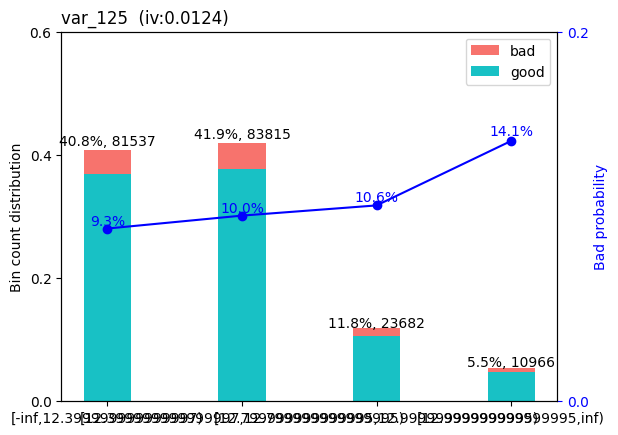

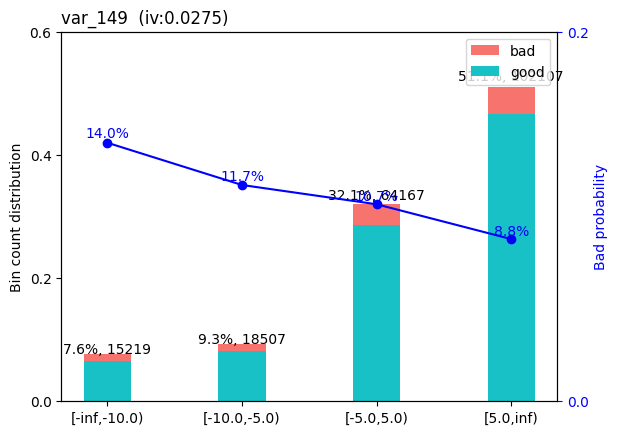

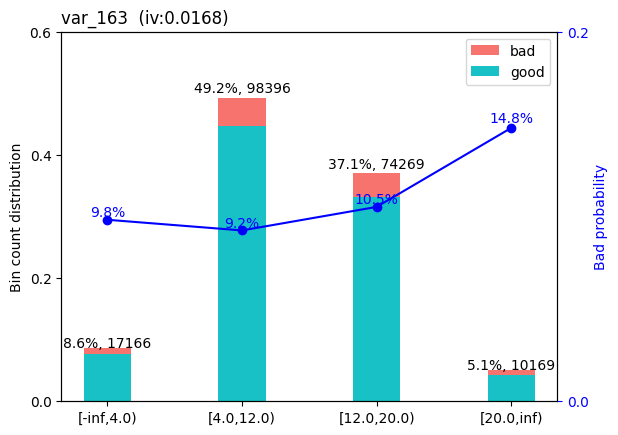

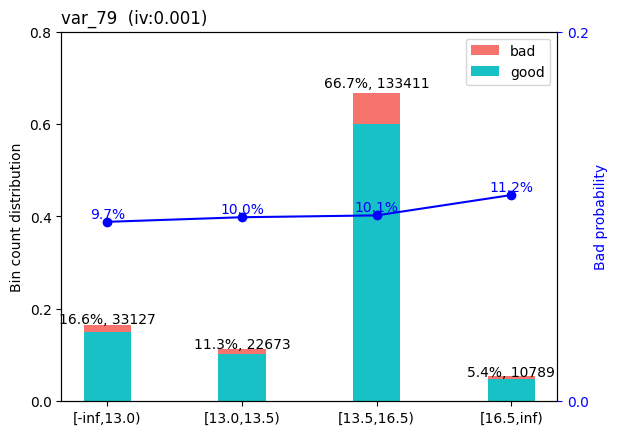

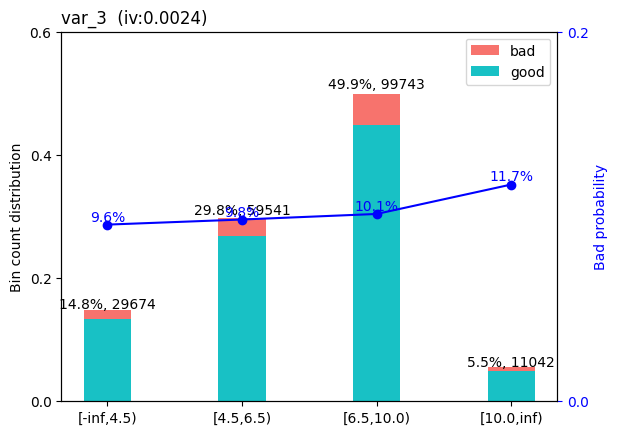

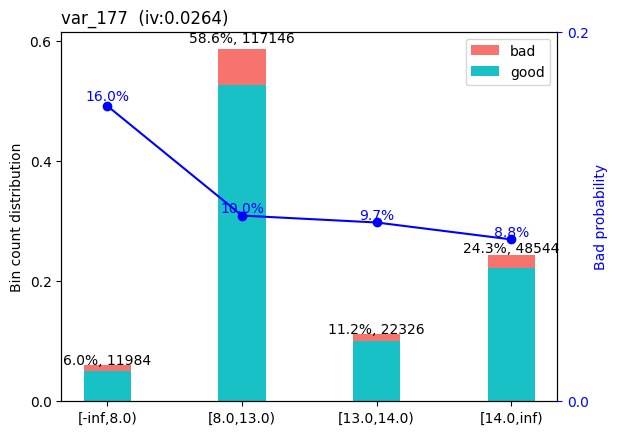

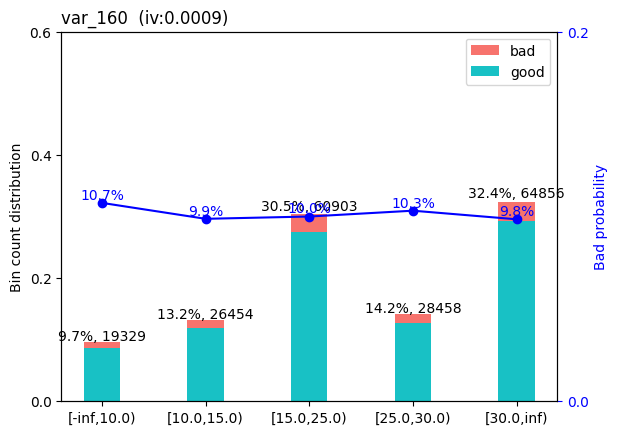

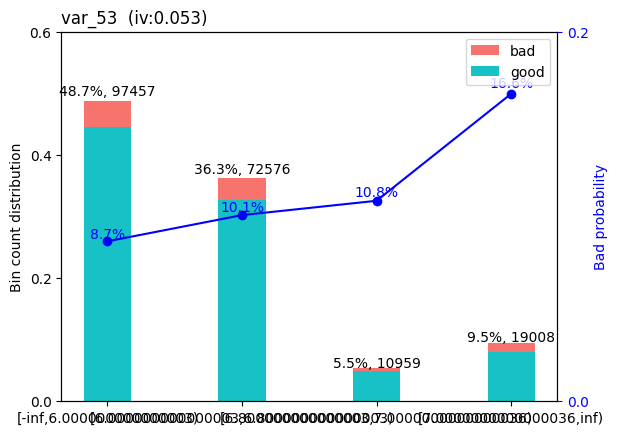

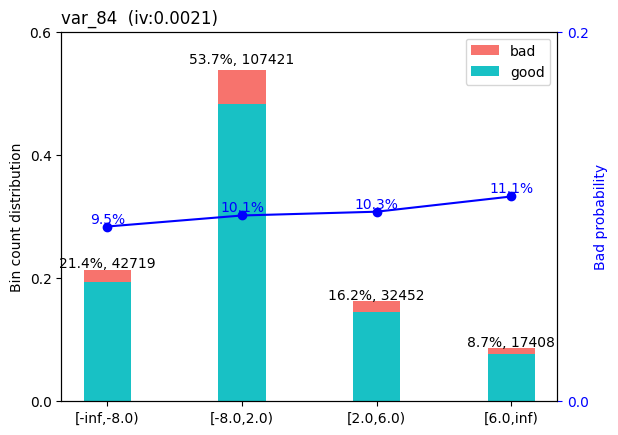

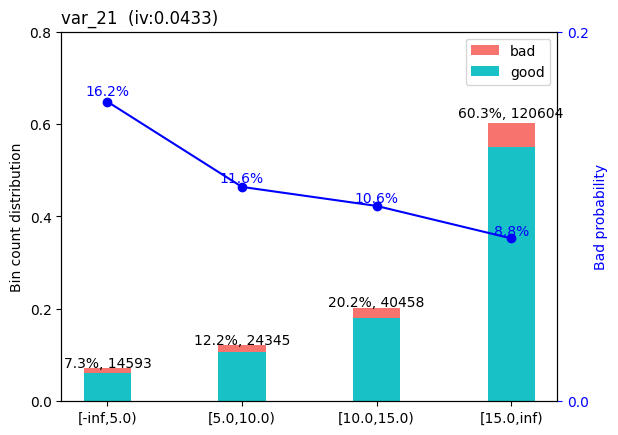

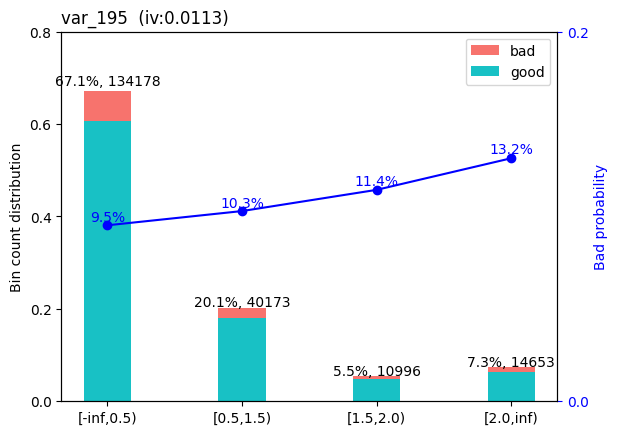

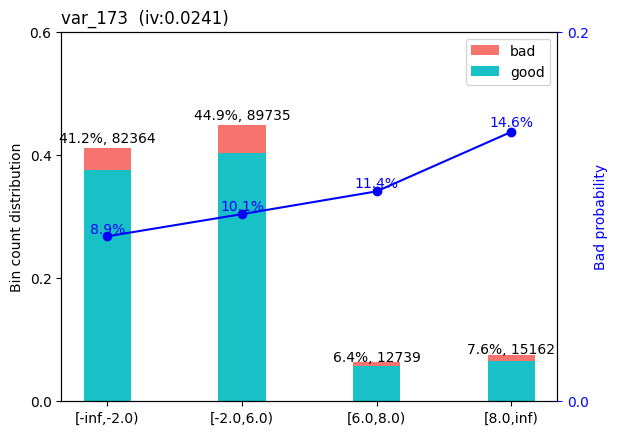

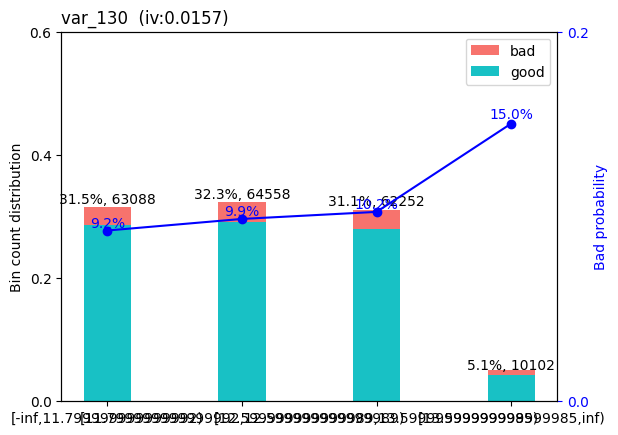

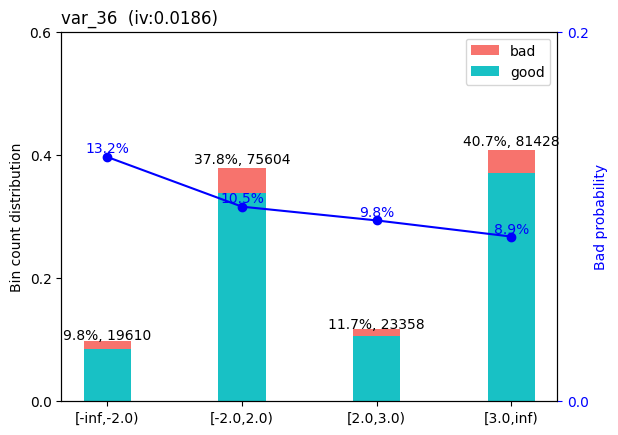

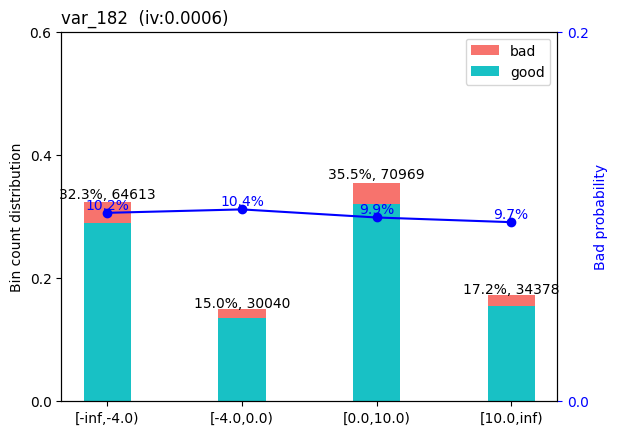

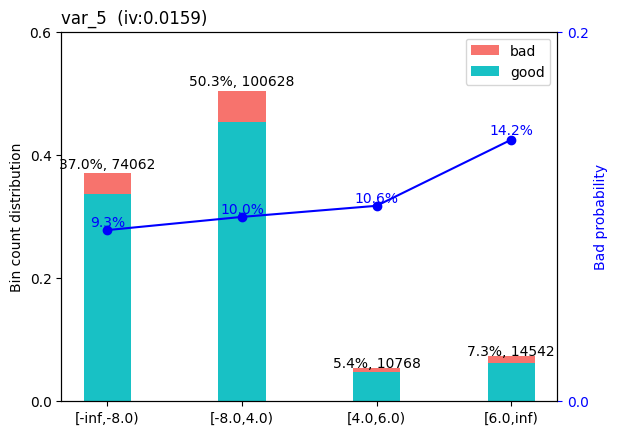

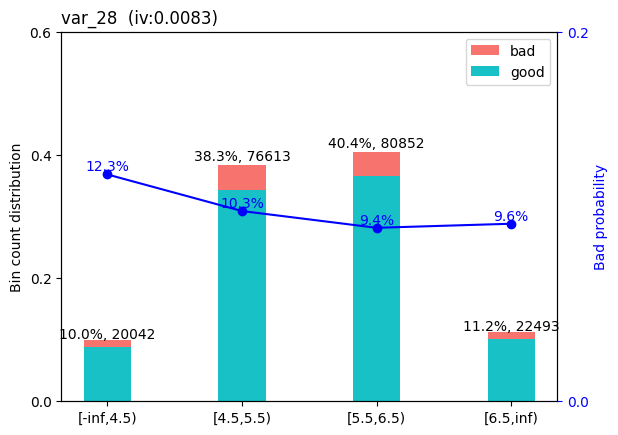

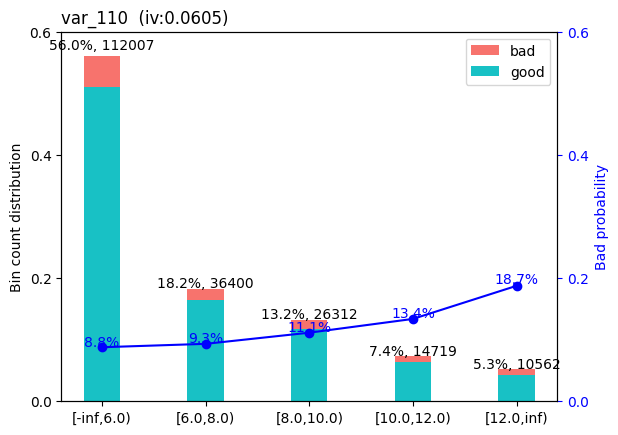

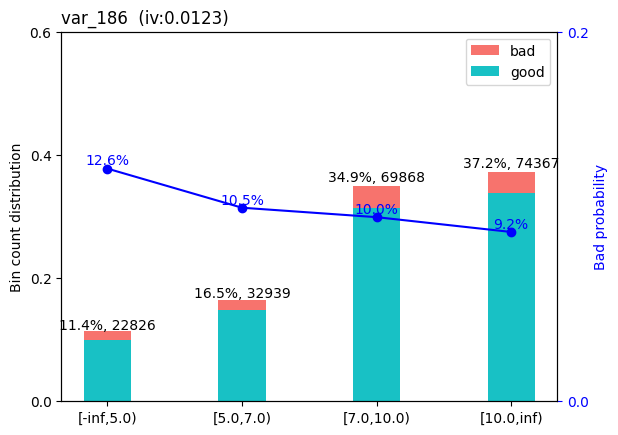

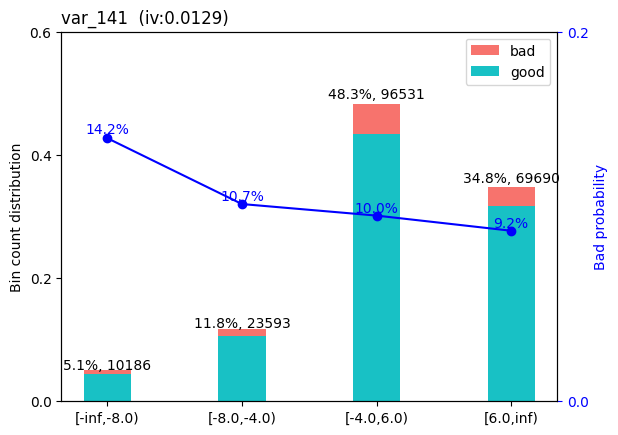

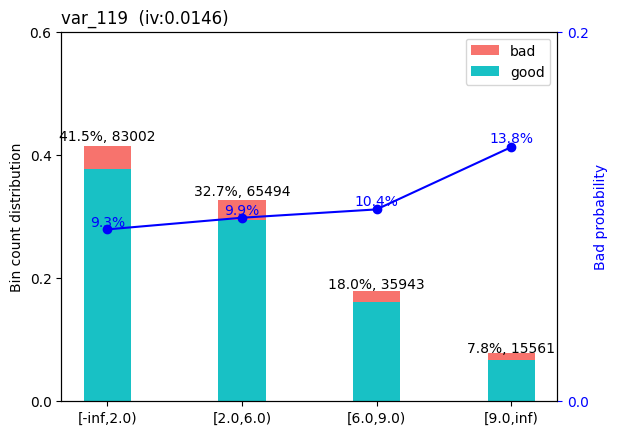

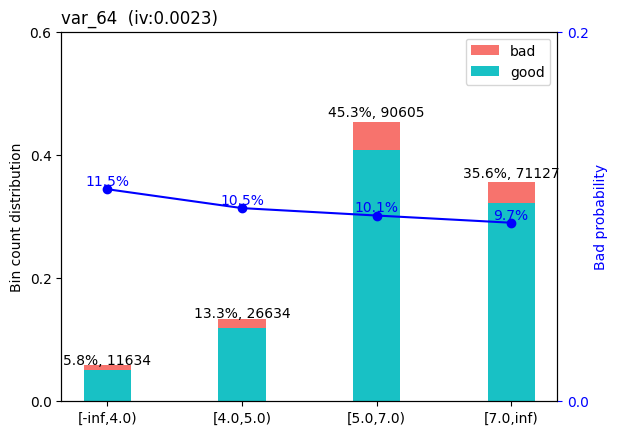

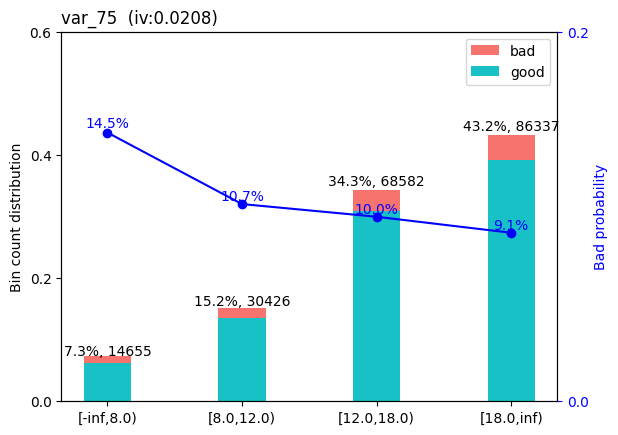

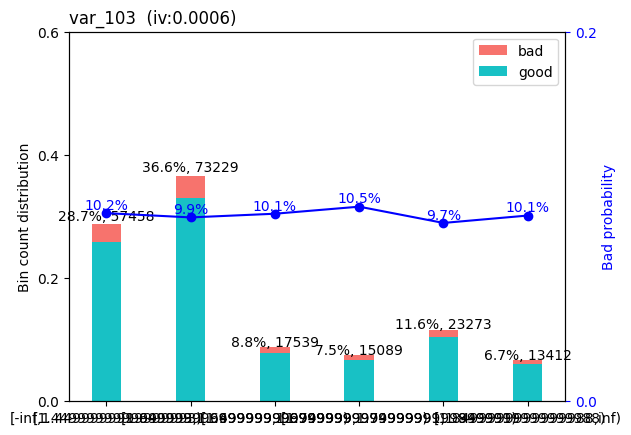

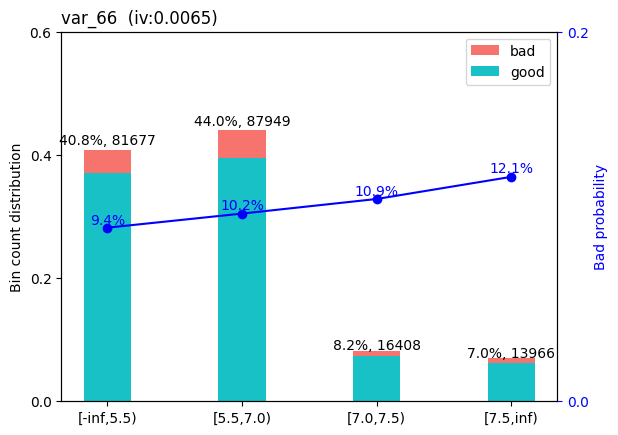

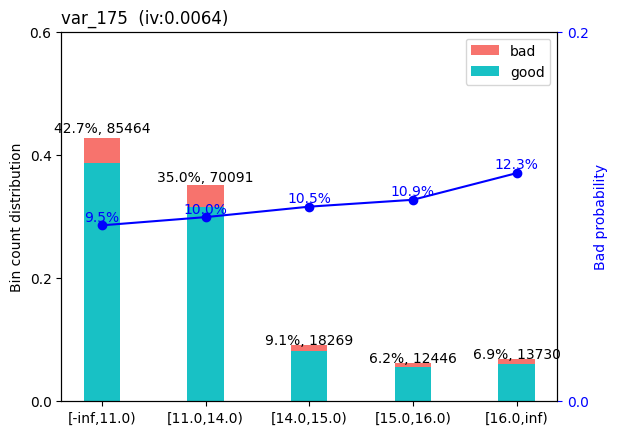

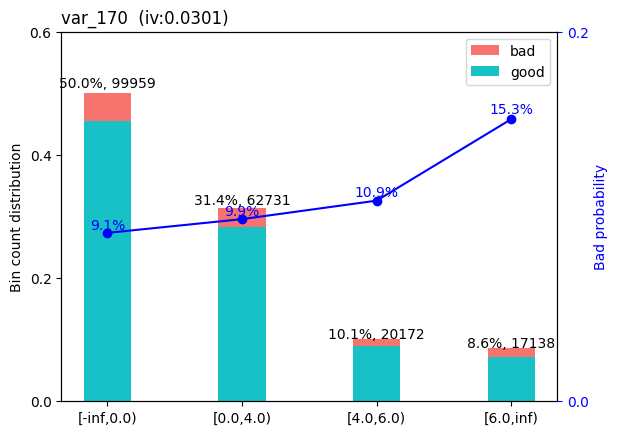

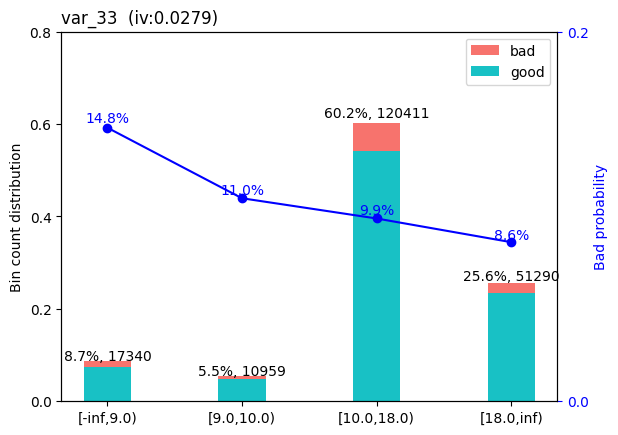

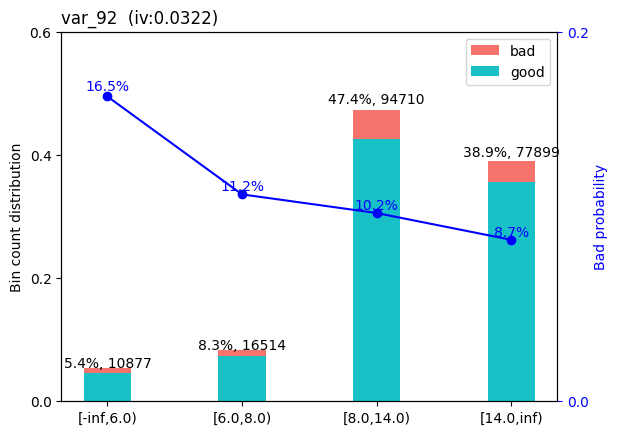

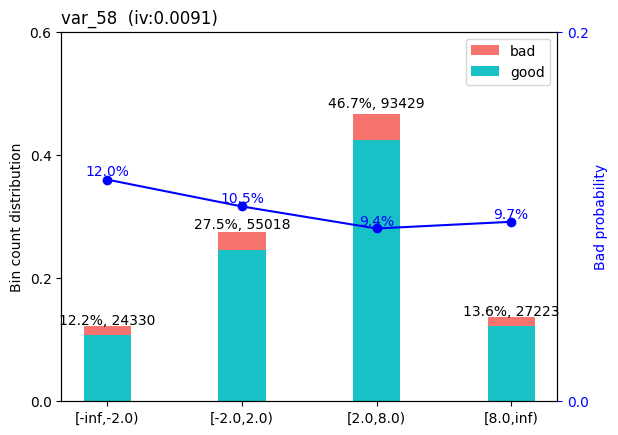

In [ ]:
bins = sc.woebin(
    train,
    y='target',
    min_perc_fine_bin=0.05,
    min_perc_coarse_bin=0.05,
    stop_limit=0.1,
    max_num_bin=8,
    method='tree'
)

sc.woebin_plot(bins)

# Feature Engineering & Model Building

In [19]:
features = [x for x in train.columns if x.startswith("var")]

hist_df = pd.DataFrame()

for var in features:
    var_stats = train[var].value_counts()
    hist_df[var] = pd.Series(test[var]).map(var_stats)
    hist_df[var] = hist_df[var] > 1

ind = hist_df.sum(axis=1) != 200
var_stats = {var: train[var].value_counts() for var in features}

pred = 0

for var in features:
    model = lgb.LGBMClassifier(**{
        'learning_rate': 0.05,
        'max_bin': 165,
        'max_depth': 5,
        'min_child_samples': 150,
        'min_child_weight': 0.1,
        'min_split_gain': 0.0018,
        'n_estimators': 41,
        'num_leaves': 6,
        'reg_alpha': 2.0,
        'reg_lambda': 2.54,
        'objective': 'binary',
        'n_jobs': -1
    })
    model = model.fit(np.hstack([train[var].values.reshape(-1, 1),
                      train[var].map(var_stats[var]).values.reshape(-1, 1)]), train["target"].values)
    pred += logit(model.predict_proba(np.hstack([test[var].values.reshape(-1, 1),
                  test[var].map(var_stats[var]).values.reshape(-1, 1)]))[:, 1])

/tmp/ipykernel_34/2137184001.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hist_df[var] = pd.Series(test[var]).map(var_stats)
/tmp/ipykernel_34/2137184001.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hist_df[var] = pd.Series(test[var]).map(var_stats)
/tmp/ipykernel_34/2137184001.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragme

[LightGBM] [Info] Number of positive: 20098, number of negative: 179902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 177
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.100490 -> initscore=-2.191792
[LightGBM] [Info] Start training from score -2.191792
[LightGBM] [Info] Number of positive: 20098, number of negative: 179902
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 176
[LightGBM] [Info] Number of data points in the train set: 200000, number of used features: 2
[LightGBM] [Info] 

# Generate submission

In [35]:
pd.DataFrame({"ID_code": test_id, "target": pred}).to_csv("submission.csv", index = False)

print("Successfully saved as CSV file")

Successfully saved as CSV file
